
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [ ]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [1]:
#!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
#!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

In [3]:
!pip install tensorflow_text>=2.0.0rc0
!pip install sentencepiece
!pip install tf_sentencepiece

#!pip install bert-tensorflow
#!pip install --upgrade bert
!pip install tokenization
!pip install bert-for-tf2
!pip install pandas

     ---------------------------------------- 10.9/10.9 MB 1.5 MB/s eta 0:00:00


In [4]:
#all imports
import numpy as np
import re
import bert
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import TerminateOnNaN,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,ModelCheckpoint
from keras.callbacks import TensorBoard

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [6]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv("Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [12]:
#get only 2 columns - Text, Score
drop_columns = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary']
reviews = reviews.drop(drop_columns, axis=1)

In [13]:
reviews['Score'].isna().sum(), reviews['Text'].isna().sum()

(0, 0)

In [14]:
#drop the NAN values
reviews = reviews.dropna()

In [15]:
#if score == 3, remove the rows. 
reviews.drop(reviews[reviews['Score'] == 3].index, inplace = True)
#if score> 3, set score = 1
#if score<=2, set score = 0
reviews['Score'] = (reviews['Score'] > 3).astype(int)
reviews.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [16]:
reviews.shape

(525814, 2)

In [17]:
reviews.Score.value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525814 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   525814 non-null  int32 
 1   Text    525814 non-null  object
dtypes: int32(1), object(1)
memory usage: 10.0+ MB


In [19]:
reviews.describe()

,Score
count,525814.000000
mean,0.843981
std,0.362874
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


<font size=4>Grader function 2 </font>

In [20]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1] == 443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [21]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 64117 to 19261
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   100000 non-null  int32 
 1   Text    100000 non-null  object
 2   len     100000 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 2.7+ MB


In [22]:
reviews.head(5)

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [23]:
reviews["Text"].iloc[64]

'THE BEST garlic oil ever, hands down!<br />Try it on pop corn WOW!!<br />BUT a 2 yr. old could have packaged it better GRR!!'

In [24]:
#remove HTML from the Text column and save in the Text column only
def remove_html(text):

  #Delete all the tags like "< anyword >"
  clean = re.compile('<.*?>')
  text=re.sub(clean,' ',text)

  #Remove all the newlines('\n'), tabs('\t'), "-", "\".
  text= re.sub(r"[\n\t-]*", "", text)

  return text

In [25]:
reviews.shape[0]

100000

In [26]:
removed_html_text_data=[]

for i in tqdm(range(reviews.shape[0])):
  removed_html_text_data.append(remove_html(reviews['Text'].values[i]))


100%|██████████| 100000/100000 [00:04<00:00, 24839.80it/s]


In [27]:
#print head 5
reviews['Text'] = removed_html_text_data
reviews.head(5)

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [28]:
reviews["Text"].iloc[64]

'THE BEST garlic oil ever, hands down! Try it on pop corn WOW!! BUT a 2 yr. old could have packaged it better GRR!!'

In [29]:
reviews.columns

Index(['Score', 'Text', 'len'], dtype='object')

In [30]:
reviews.shape

(100000, 3)

In [31]:
X = pd.DataFrame()
X['Text'] = reviews['Text']
X['len'] = reviews['len']
y = pd.DataFrame()
y['Score'] = reviews['Score']

In [33]:
!pip install scikit-learn

     ---------------------------------------- 7.6/7.6 MB 1.7 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 2.0 MB/s eta 0:00:00


In [34]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=y,random_state=33)


In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(80000, 2)
(20000, 2)
(80000, 1)
(20000, 1)


<AxesSubplot: xlabel='Score'>

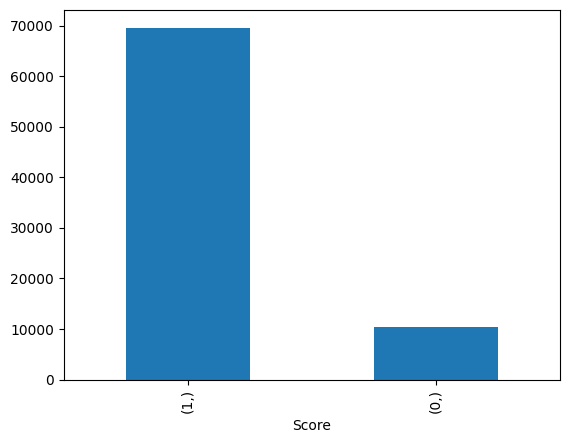

In [36]:
#Bar graph for y_train 
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar')

<AxesSubplot: xlabel='Score'>

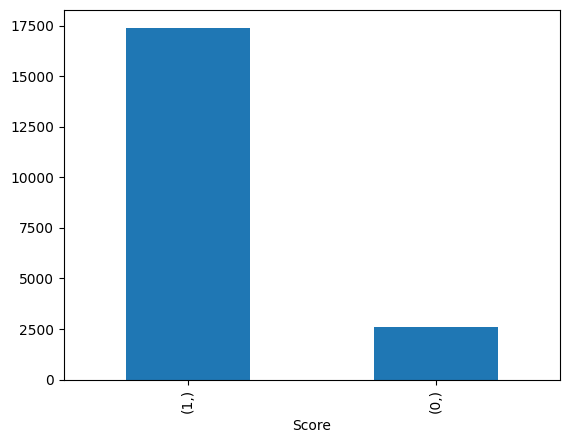

In [37]:
#Bar Graph for y_test data
y_test.value_counts().plot(kind='bar')


In [38]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)


<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [39]:
!pip install pydot 
!pip install graphviz 
!pip install pydot_ng

     -------------------------------------- 47.0/47.0 kB 168.0 kB/s eta 0:00:00


In [40]:
tf.keras.backend.clear_session()
#BERT takes 3 inputs
#this is input words. Sequence of words represented as integers
#mask vector if you are padding anything
#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
max_seq_length = 55
input_word_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_type_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable= False)
#bert_inputs = dict(input_word_ids = input_word_ids,input_mask = input_mask, input_type_ids = input_type_ids)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=pooled_output)

In [41]:
bert_model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [42]:
#bert_model,bert_layer = create_model()
#bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss= tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [43]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_type_ids')>]

In [44]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [45]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

label_list = [0,1] # Label categories
max_seq_length = 55  # maximum length of (token) input sequences
train_batch_size = 32

#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

<font size=4>Grader function 3 </font>

In [46]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

In [47]:
def create_bert_inputs(input_data,tokenizer):

    input_tokens  = []
    input_mask    = []
    input_segment = []

    for reviews in input_data["Text"]:              # reviews = "[CLS]" + reviews + "[SEP]"
        tokens = tokenizer.tokenize(reviews)                     # split words in review            
        if len(tokens) >= 54:                                    # if length of sentence is greater than 54, truncate
            tokens = tokens[:53]
        tokens = ['[CLS]',*tokens,'[SEP]']                       # add ['CLS'] to start and ['SEP'] to the end    
        
        if len(tokens)<55:                          # if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)          
            while len(tokens) < 55:                 # add the word ['PAD'] in remaining places
                tokens.append('[PAD]')                                            
        
        masked=[]
        for i in tokens:
            if i!='[PAD]':                          # fill mask_array with 0 in place of ['PAD'] and 1 otherwise
                masked.append(1)
            else:
                masked.append(0)
        input_mask.append(masked)
    
        tokens = tokenizer.convert_tokens_to_ids(tokens)         # adding positional encoding to words
        input_tokens.append(tokens)    
    
        segment = [0]*55                                         # since inputting only 1 sentence giving segments as all zeroes
        input_segment.append(segment)

    input_tokens  =  np.array(input_tokens)                      # type of all the above arrays should be numpy arrays
    input_mask    =  np.array(input_mask)
    input_segment =  np.array(input_segment)

    return input_tokens,input_mask,input_segment

In [48]:
X_train_tokens,X_train_mask,X_train_segment = create_bert_inputs(X_train,tokenizer)  ## Train_data inputs for BERT

X_test_tokens,X_test_mask,X_test_segment    = create_bert_inputs(X_test,tokenizer)   ## Test_data inputs for BERT

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [49]:
import pickle

In [50]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [51]:
#you can load from disk
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 
# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [52]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [53]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [54]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_type_ids')>]

In [55]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [56]:
X_train_segment[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [58]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

filepath="best_model.hdf5"
CheckPoint = ModelCheckpoint(filepath=model_save_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='min')

tb  = TensorBoard(log_dir=log_dir)

callbacks = [CheckPoint,tb]

In [59]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
#tokens_array,mask_array,segment_array = create_bert_inputs(input_data,tokenizer)    
# Creating inputs for bert model
from sklearn.metrics import confusion_matrix,f1_score,classification_report

X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment],batch_size=32)
X_train_pred_labels = X_train_pooled_output.argmax(axis=1)

2500/2500 [==============================] - 746s 297ms/step


In [60]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens, X_test_mask, X_test_segment],batch_size=32)
X_test_pred_labels = X_test_pooled_output.argmax(axis=1)


625/625 [==============================] - 183s 294ms/step


In [62]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [63]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

In [68]:
X_train_pooled_output.shape, X_test_pooled_output.shape

((80000, 768), (20000, 768))

In [69]:
len(y_train.shape), len(y_test.shape)

(2, 2)

In [70]:
X_train_pooled_output

array([[-0.900273  , -0.34739542, -0.9403269 , ..., -0.90477073,
        -0.65887487,  0.9167845 ],
       [-0.8217009 , -0.28934422, -0.8032384 , ..., -0.75571686,
        -0.66162056,  0.8885183 ],
       [-0.8107029 , -0.39052856, -0.86496013, ..., -0.81251943,
        -0.6491288 ,  0.89500415],
       ...,
       [-0.58643985, -0.44026846, -0.9627425 , ..., -0.8420664 ,
        -0.64556086,  0.7161623 ],
       [-0.51534706, -0.23186147, -0.9440779 , ..., -0.8851118 ,
        -0.5005765 ,  0.60448426],
       [-0.91460544, -0.5183219 , -0.8648384 , ..., -0.7172572 ,
        -0.75686437,  0.9463819 ]], dtype=float32)

In [73]:
X_train_tokens.shape

(80000, 55)

In [74]:
X_train_mask.shape

(80000, 55)

<font size=4>Grader function 6 </font>

In [75]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [76]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [81]:
!pip install pydot
!pip install graphviz 

In [77]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [78]:
from tensorflow.keras import regularizers
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
#input_layer=Input(shape=(X_train_pooled_output.shape[1],))
##create an NN and 
bert_emb = Input(shape=(768,),name="bert_emb")
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(bert_emb)
#x=Dropout(0.5)(x)
x = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
#x=Dropout(0.4)(x)
x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
#x=Dropout(0.3)(x)
x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model = Model(inputs=[bert_emb],outputs=[output])

In [83]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert_emb (InputLayer)       [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 240,162
Trainable params: 240,162
Non-trainab

In [84]:
#Model Architechture:
#tf.keras.utils.plot_model(model,show_shapes=False, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=96)

In [85]:
import tensorflow 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam
import datetime 
from tensorflow.keras.utils import to_categorical

## AUC score 
def aucroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

Y_train_ohe = to_categorical(y_train)  ## converting y_train and y_test to one hot encoded values
Y_test_ohe = to_categorical(y_test)

## TENSORBOARD callback
tb = TensorBoard(log_dir='./Graph', histogram_freq=2,write_graph=True, write_images=True)
tb.set_model(model)

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy',aucroc])


In [86]:
history = model.fit(X_train_pooled_output,Y_train_ohe,epochs=15,batch_size=150,validation_data=(X_test_pooled_output,Y_test_ohe),callbacks = tb )

Epoch 1/15
534/534 [==============================] - 4s 7ms/step - loss: 0.6022 - accuracy: 0.8931 - aucroc: 0.8950 - val_loss: 0.3863 - val_accuracy: 0.9098 - val_aucroc: 0.9372
Epoch 2/15
534/534 [==============================] - 3s 6ms/step - loss: 0.3410 - accuracy: 0.9140 - aucroc: 0.9455 - val_loss: 0.2953 - val_accuracy: 0.9239 - val_aucroc: 0.9434
Epoch 3/15
534/534 [==============================] - 3s 6ms/step - loss: 0.3005 - accuracy: 0.9149 - aucroc: 0.9487 - val_loss: 0.2821 - val_accuracy: 0.9181 - val_aucroc: 0.9446
Epoch 4/15
534/534 [==============================] - 3s 6ms/step - loss: 0.2702 - accuracy: 0.9183 - aucroc: 0.9511 - val_loss: 0.2675 - val_accuracy: 0.9188 - val_aucroc: 0.9462
Epoch 5/15
534/534 [==============================] - 4s 7ms/step - loss: 0.2564 - accuracy: 0.9193 - aucroc: 0.9521 - val_loss: 0.2420 - val_accuracy: 0.9241 - val_aucroc: 0.9453
Epoch 6/15
534/534 [==============================] - 3s 6ms/step - loss: 0.2418 - accuracy: 0.9222 

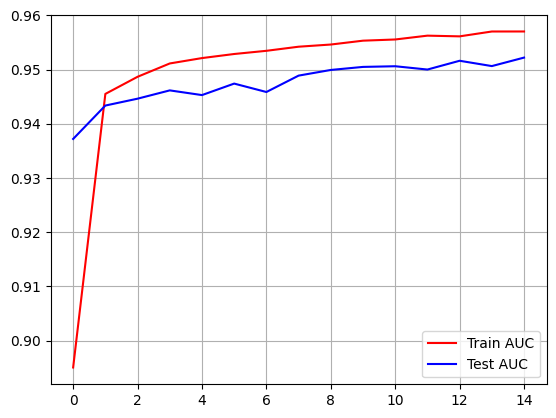

In [87]:
from matplotlib import pyplot as plt 
plt.plot(history.history['aucroc'], 'r')
plt.plot(history.history['val_aucroc'], 'b')
plt.legend({'Train AUC': 'r', 'Test AUC':'g'})
plt.grid()
plt.show()

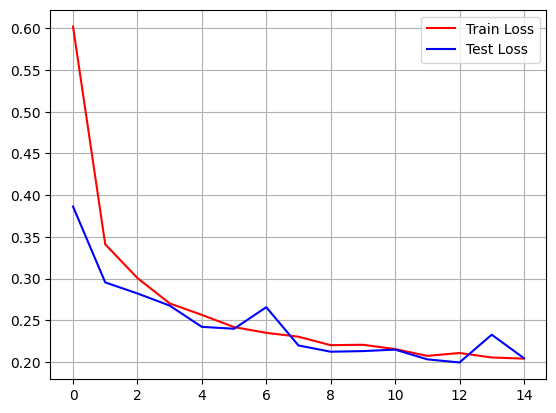

In [88]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'g'})
plt.grid()
plt.show()

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [89]:
#read the csv file
test_df= pd.read_csv('test.csv')

In [94]:
test_df.head()

,Text,predicted_y
0,Just opened Greenies Joint Care (individually ...,0
1,This product rocks :) My mom was very happy w/...,1
2,"The product was fine, but the cost of shipping...",1
3,I love this soup. It's great as part of a meal...,1
4,Getting ready to order again. These are great ...,1


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [90]:
def Test_data_embedding(input_data, model, tokenizer):
    
    input_data.dropna(subset = ["Text"], inplace=True)                                  # remove datapoints with Nan values
    input_data['Text'] = input_data['Text'].str.replace(r'<[^<>]*>', '', regex=True)    # remove HTML tags
      
    tokens_array,mask_array,segment_array = create_bert_inputs(input_data,tokenizer)    # Creating inputs for bert model(tokenization)
    
    X_test = model.predict([tokens_array,mask_array,segment_array])                     # Embedding using BERT model
    print('Shape of X_test after embedding using BERT model :',X_test.shape)
    
    return X_test

In [91]:
X_test = Test_data_embedding(test_df, bert_model, tokenizer)

11/11 [==============================] - 3s 287ms/step
Shape of X_test after embedding using BERT model : (352, 768)


In [92]:
# predicting class label from previously for previous model
prediction = model.predict(X_test)
predicted_y = prediction.argmax(axis=-1)

11/11 [==============================] - 0s 4ms/step


In [93]:
test_df['predicted_y'] = predicted_y
test_df.head(5)

,Text,predicted_y
0,Just opened Greenies Joint Care (individually ...,0
1,This product rocks :) My mom was very happy w/...,1
2,"The product was fine, but the cost of shipping...",1
3,I love this soup. It's great as part of a meal...,1
4,Getting ready to order again. These are great ...,1


## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

From the above dataframe, for each text review the corresponding class label/sentiment score is provided and from observing the above given 5 observations.

The prediction was made using the previously trained neural network model.

In this assignmet,the BERT uncased model model was used.

The Steps for predicting the class labels are :

In the Preprocessing step the input dataset was performed,followed by splitting to train and test dataset.

Then the BERT uncased model was downloaded from tensorflow HUB and the model was createed.

The BERT model needs 3 inputs : word_ids/tokens, input mask and segment_ids.The maximum size allowed for all these 3 inputs is 55. If the length of input was less than 55 padding was performed and if the length of input was greater than 55 truncation was performed

The tokens were created using the tokenizer module which has functions for converting words to tokens and for positional encoding. 

The mask input was created by filling 0s to the places that were padded(represented by 'PAD') and 1s to the other places. 

The segment_ids were made to all zeros as here we are giving only one sentence at a time.

Then Embedding was obtained by giving these 3 inputs to the BERT model. The output was of 768 dimension.

Then a simple neural network was created with the embedding vector given as the input and it was trained with 15 epochs.

The model gave an a test accuracy of 0.9257 and test AUC score of 0.9522.

Then the test dataset 'test_df' was provided.

While creating data pipeline above process was repeated with in a function. It was preprocessed, inputs for BERT model were created and embedding was obtained. after that previously trained neural network model to predict the sentiment scores for the reviews.